# Imports

In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
from scipy.optimize import curve_fit

# Constants

In [2]:
DATA_FILEPATH = Path.cwd() / '..' / 'data.csv'

# Helper functions

In [3]:
# Basic function of exponential evolution
def exponential_growth(t, pzero, growth_rate):
    return pzero * (1+growth_rate)**t
    
# Function to fit an exponential to experimental data and return the data
def fit_exponential(xdata, ydata, func=exponential_growth): 
    popt, pcov = curve_fit(func, xdata, ydata)
    new_vals = func(xdata, *popt)
    print("Standard deviation of the parameters during fit: {}".format(np.sqrt(np.diag(pcov))))
    return new_vals, popt[-1], popt

---

# Reading the data

Let's fill all NaN values with 0 (_under the naïve assumption that the lack of data means absence of cases_).

In [4]:
data = pd.read_csv(DATA_FILEPATH, parse_dates=[0], index_col=[0], infer_datetime_format=True)
data.fillna(value=0).head(5)

,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,confirmados_novos,recuperados,obitos,internados,internados_uci,lab,suspeitos,vigilancia,cadeias_transmissao,transmissao_importada,transmissao_comunitaria
data,,,,,,,,,,,,,,,,,,,,
2020-02-26,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,25,0.0,0.0,0.0,0.0
2020-02-27,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,51,0.0,0.0,0.0,0.0
2020-02-28,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,59,0.0,0.0,0.0,0.0
2020-02-29,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,70,0.0,0.0,0.0,0.0
2020-03-01,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,85,0.0,0.0,0.0,0.0


The columns we have: 

# Inspecting the growth curves in ARS Norte and ARS Lisboa e Vale do Tejo

Looking at the numbers per region, we see that the growth in new cases in the _Lisboa e Vale do Tejo_ region has picked up in the last few days, after a rather slow start when compared to the Norte region, the main propagation cluster in the country in the first days. Let's confirm visually: 

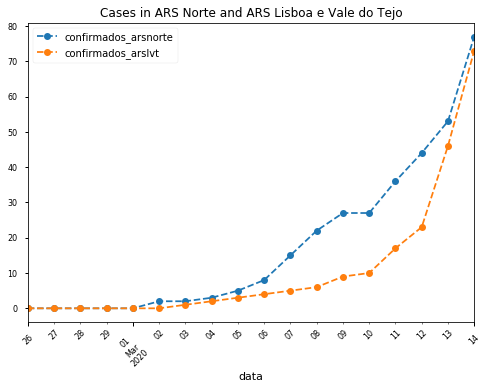

In [5]:
data[['confirmados_arsnorte', 'confirmados_arslvt']].plot(kind='line', title='Cases in ARS Norte and ARS Lisboa e Vale do Tejo', linestyle='--', marker='o', rot=45, fontsize=8)

Let's try and fit an exponential curve to each of these curves. Let's assume a basic exponential growth model for demo purposes ( [source - Wikipedia](https://en.wikipedia.org/wiki/Exponential_growth) ): 

$ x(t) = x_0 * (1+r)^t $

Where $x(t)$ is the number of cases, $x_0$ the number of infected at time $t=0$ and $r$ the exponential growth factor. $t$, the passage of time, is taken in days.

**Real world virology propagation is more complex and is affected by a number of externalities (say, the preventive and prophylactic measures taken by the population).**

**DO NOT TRUST THE DATA BELOW, IT'S ONLY FOR DEMOSNTRATIVE PURPOSES.** 

In [6]:
arsnorte_fit_data, growth_rate_norte, params_norte = fit_exponential(np.arange(0, len(data.index)), data.confirmados_arsnorte.values)
arslvt_fit_data, growth_rate_lvt, params_lvt = fit_exponential(np.arange(0, len(data.index)), data.confirmados_arslvt.values)

Standard deviation of the parameters during fit: [0.21428943 0.01697938]
Standard deviation of the parameters during fit: [0.0065653  0.03194738]


Let's visualize them both together, as well as the original data: 

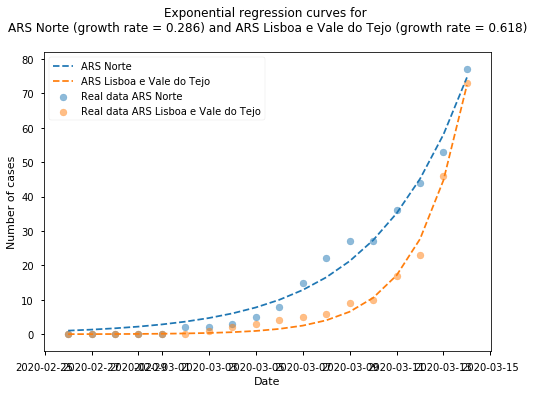

In [7]:
fig, ax = plt.subplots(1,1)

# Plotting the exponential curves
ax.plot(data.index, arsnorte_fit_data, '--', label='ARS Norte')
ax.plot(data.index, arslvt_fit_data, '--', label='ARS Lisboa e Vale do Tejo')

# Adding the real data
ax.scatter(data.index, data.confirmados_arsnorte, marker='o', label='Real data ARS Norte', alpha=0.5)
ax.scatter(data.index, data.confirmados_arslvt, marker='o', label='Real data ARS Lisboa e Vale do Tejo', alpha=0.5)

ax.set_title('Exponential regression curves for \nARS Norte (growth rate = {:.3f}) and ARS Lisboa e Vale do Tejo (growth rate = {:.3f})\n'.format(growth_rate_norte, growth_rate_lvt))
ax.set_xlabel('Date')
ax.set_ylabel('Number of cases')
plt.legend()
plt.show()

## Shall we visualize this trend a bit into the future?

Let's say... 2 weeks into the future: 

In [8]:
dates = pd.date_range(start=data.index[0], end=data.index[-1]+pd.Timedelta(value=14, unit='D'), freq='D')

Computing the curves:

In [9]:
prediction_arsnorte = exponential_growth(np.arange(0, len(dates)), *params_norte)
prediction_arslvt = exponential_growth(np.arange(0, len(dates)), *params_lvt)

Visualizing:

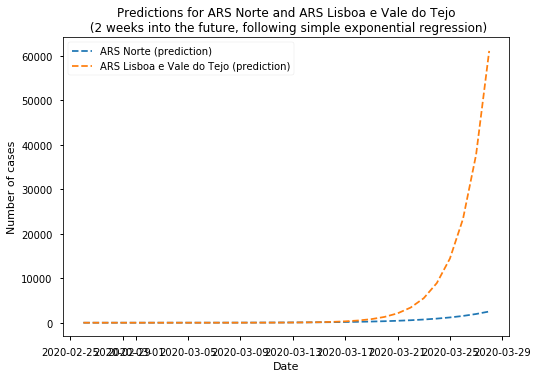

In [10]:
fig, ax = plt.subplots(1,1)

# Plotting the exponential curves
ax.plot(dates, prediction_arsnorte, '--', label='ARS Norte (prediction)')
ax.plot(dates, prediction_arslvt, '--', label='ARS Lisboa e Vale do Tejo (prediction)')

ax.set_title('Predictions for ARS Norte and ARS Lisboa e Vale do Tejo\n (2 weeks into the future, following simple exponential regression)'.format(growth_rate_norte, growth_rate_lvt))
ax.set_xlabel('Date')
ax.set_ylabel('Number of cases')
plt.legend()
plt.show()

_Ooopsie._

# Conclusion

It looks quite drastic, huh? Yes, but **YOU SHOULD NOT TRUST THIS ANALYSIS**. Unless it's coming from a certified Public Health professional, epidemiologist or virology statistician, **DO NOT TRUST IT**.  

The considered model represents the extreme worst case scenario: a word in which no counter-measures whatsoever are taken. That is not currently our world. However, it's a glimpse into what could have been. 

The main and only takeway? #AchataACurva.